## Setup

In [2]:
from dslabs_functions import get_variable_types
from seaborn import heatmap
from dslabs_functions import HEIGHT, plot_multi_scatters_chart
from matplotlib.pyplot import figure, subplots, savefig, show, gcf
from dslabs_functions import plot_bar_chart
from dslabs_functions import set_chart_labels
from dslabs_functions import define_grid, HEIGHT
from matplotlib.figure import Figure
from numpy import ndarray
from dslabs_functions import *
from pandas import read_csv, DataFrame
from numpy import log
from pandas import Series
from scipy.stats import norm, expon, lognorm
from matplotlib.axes import Axes
from dslabs_functions import plot_multiline_chart

In [3]:
filename = "datasets/class_credit_score.csv"
file_tag = "credit_score"
data: DataFrame = read_csv(filename, na_values="", index_col="ID")

In [4]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option("display.max_colwidth", 200)

## Data Preparation

### Variable encoding

In [5]:
# Remove non-digits from age column and convert into numeric
data['Age'] = data['Age'].str.replace(r'[^0-9]+', '', regex=True)
data['Age'] = pd.to_numeric(data['Age'])

# Drop name column
data = data.drop(columns=['Name'])

# Leave only area code for SSN
data['SSN'] = data['SSN'].str.slice(stop=3)
data = data.rename(columns = {'SSN': 'SSN_Area_Code'})

data

,Customer_ID,Month,Age,SSN_Area_Code,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,NumofLoan,Type_of_Loan,Delay_from_due_date,NumofDelayedPayment,ChangedCreditLimit,NumCreditInquiries,CreditMix,OutstandingDebt,CreditUtilizationRatio,Credit_History_Age,Payment_of_Min_Amount,TotalEMIpermonth,Amountinvestedmonthly,Payment_Behaviour,MonthlyBalance,Credit_Score
ID,,,,,,,,,,,,,,,,,,,,,,,,,,
0x1602,CUS_0xd40,January,23,821,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan",3,7.0,11.27,4.0,NaN,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
0x1603,CUS_0xd40,February,23,821,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629163,Good
0x1604,CUS_0xd40,March,500,821,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan",3,7.0,NaN,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good
0x1605,CUS_0xd40,April,23,821,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan",5,4.0,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
0x1606,CUS_0xd40,May,23,821,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x25fe9,CUS_0x942c,April,25,078,Mechanic,39628.99,3359.415833,4,6,7,2,"Auto Loan, and Student Loan",23,7.0,11.50,3.0,NaN,502.38,34.663572,31 Years and 6 Months,No,35.104023,60.971333,High_spent_Large_value_payments,479.866228,Poor
0x25fea,CUS_0x942c,May,25,078,Mechanic,39628.99,3359.415833,4,6,7,2,"Auto Loan, and Student Loan",18,7.0,11.50,3.0,NaN,502.38,40.565631,31 Years and 7 Months,No,35.104023,54.185950,High_spent_Medium_value_payments,496.651610,Poor
0x25feb,CUS_0x942c,June,25,078,Mechanic,39628.99,3359.415833,4,6,5729,2,"Auto Loan, and Student Loan",27,6.0,11.50,3.0,Good,502.38,41.255522,31 Years and 8 Months,No,35.104023,24.028477,High_spent_Large_value_payments,516.809083,Poor


In [6]:
import numpy as np

def process_loan_type_entry(entry):
    if not isinstance(entry, float):
        loan_types_split = []
        type_list = entry.replace(' and ', ' ')
        type_list = type_list.split(', ')
        for loan_type in type_list:
            loan_types_split.append('Loan_Type_' + loan_type.strip().replace(' ', '_').replace('-', '_'))
        return loan_types_split
    return np.nan

# Split loan types and reformat the strings

no_nans = data.dropna()
loan_values = no_nans['Type_of_Loan'].unique()

loan_types = []
for entry in loan_values:
    loan_types += process_loan_type_entry(entry)

loan_types_columns = set(loan_types)
loan_types_columns = list(loan_types_columns)


# Create columns and add to dataframe

def columns_count_occurrences(column_names, list_to_count):
    column_values = dict.fromkeys(column_names, 0)
    if isinstance(list_to_count, float):    # nan
        for key in column_values:
            column_values[key] = np.nan
    else:
        for item in list_to_count:
            column_values[item] += 1
    return column_values


data[loan_types_columns] = data.apply(lambda row: columns_count_occurrences(loan_types_columns, process_loan_type_entry(row['Type_of_Loan'])), axis='columns', result_type='expand')

data = data.drop(columns = ['Type_of_Loan'])

In [7]:
# Can we drop "num of loan"?

data = data.drop(columns = ['NumofLoan'])

In [8]:
# Convert credit history to months

import re

def convert_age_to_months(age):
    if isinstance(age, str):
        list_of_numbers = re.findall(r'\b\d+\b', age)
        if (len(list_of_numbers) != 2):
            print(list_of_numbers)
            raise Exception('Incorrect age input')
        years, months = int(list_of_numbers[0]), int(list_of_numbers[1])
        total_months = years * 12 + months
        return total_months
    return np.nan

data['Credit_History_Age_Months'] = data.apply(lambda row: convert_age_to_months(row['Credit_History_Age']), axis='columns', result_type='expand')
data = data.drop(columns=["Credit_History_Age"])

In [9]:
def dummify(df: DataFrame, vars_to_dummify: list[str]) -> DataFrame:
    other_vars: list[str] = [c for c in df.columns if not c in vars_to_dummify]

    enc = OneHotEncoder(
        handle_unknown="ignore", sparse_output=False, dtype="bool", drop="if_binary"
    )
    trans: ndarray = enc.fit_transform(df[vars_to_dummify])

    new_vars: ndarray = enc.get_feature_names_out(vars_to_dummify)

    dummy = DataFrame(trans, columns=new_vars, index=df.index)

    final_df: DataFrame = concat([df[other_vars], dummy], axis=1)
    return final_df

def encode_cyclic_variables(data: DataFrame, vars: list[str]):
    _data = data
    for v in vars:
        x_max: float = max(data[v])
        _data[v + "_sin"] = data[v].apply(lambda x: round(sin(2 * pi * x / x_max), 5))
        _data[v + "_cos"] = data[v].apply(lambda x: round(cos(2 * pi * x / x_max), 5))
    return _data


# Substitutions

payment_behaviour_enc: dict[str, int] = {"High_spent_Small_value_payments": 10, "Low_spent_Large_value_payments": 2, 
                                         "Low_spent_Medium_value_payments": 1, "Low_spent_Small_value_payments": 0,
                                         "High_spent_Medium_value_payments": 11, "High_spent_Large_value_payments": 12}
credit_mix_enc: dict[str, int] = {"Good": 2, "Standard": 1, "Bad": 0}
credit_score_enc: dict[str, int] = {"Good": 1, "Poor": 0}
payment_min_amount_enc: dict[str, int] = {"Yes": 2, "NM": 1, "No": 0}
month_val: dict[str, float] = {
    "January": 0,
    "February": pi / 4,
    "March": 2 * pi / 4,
    "April": 3 * pi / 4,
    "May": pi,
    "June": - 3 * pi / 4,
    "July": - 2 * pi / 4,
    "August": - pi / 4
}

encoding: dict[str, dict[str, int]] = {
    "Payment_Behaviour": payment_behaviour_enc,
    "CreditMix": credit_mix_enc,
    "Month": month_val,
    "Credit_Score": credit_score_enc,
    "Payment_of_Min_Amount": payment_min_amount_enc
}


# Replace values on dataframe

data = data.replace(encoding, inplace=False)

vars = ["Occupation"]
data = dummify(data, vars)

data['Customer_ID'] = data.apply(lambda row: int(row['Customer_ID'].replace('CUS_', ''), 16), axis='columns', result_type='expand')

data = encode_cyclic_variables(data, ["Month"])
data = data.drop(columns=['Month'])

### Missing value imputation

#### 2nd approach

In [10]:
# Phase 1: dropping MVs (records and variables)

data_mvi_1 = data.copy()

def mvi_by_dropping(
    data: DataFrame, min_pct_per_variable: float = 0.1, min_pct_per_record: float = 0.0
) -> DataFrame:
    # Deleting variables
    df: DataFrame = data.dropna(
        axis=1, thresh=data.shape[0] * min_pct_per_variable, inplace=False
    )
    # Deleting records
    df.dropna(axis=0, thresh=data.shape[1] * min_pct_per_record, inplace=True)

    return df


cols_before_drop = data_mvi_1.columns

# "thresh=N requires that a column has at least N non-NaNs to survive"
data_mvi_1 = mvi_by_dropping(data_mvi_1, min_pct_per_variable=0.1, min_pct_per_record=0.1)

print('Removed columns:')
print(list(set(cols_before_drop) - set(data_mvi_1.columns)))
print(data_mvi_1.shape)

Removed columns:
[]
(100000, 49)


In [11]:
# Phase 2: filling MVs

from numpy import ndarray
from pandas import concat
from sklearn.impute import SimpleImputer, KNNImputer
from dslabs_functions import get_variable_types, mvi_by_filling

def mvi_by_filling_per_column(data: DataFrame, cols: list, strategy: str = "mean") -> Series:
    # Possible strategies: "mean", "median", "most_frequent"
    if strategy != "knn":
        imp = SimpleImputer(strategy=strategy, copy=True)
        df = DataFrame(
            imp.fit_transform(data[cols]),
            columns=cols,
        )
        return df[cols]
    else:
        imp = KNNImputer(n_neighbors=5)
        imp.fit(data)
        ar: ndarray = imp.transform(data)
        df = DataFrame(ar, columns=data.columns, index=data.index)
    return df[cols]

knn_cols = ['SSN_Area_Code', 'CreditMix', 'Amountinvestedmonthly', 'MonthlyBalance']
data_mvi_1[knn_cols] = mvi_by_filling_per_column(data_mvi_1, knn_cols, 'knn')[knn_cols]

data_mvi_3 = data.copy()
knn_cols_3 = ['SSN_Area_Code', 'CreditMix', 'Amountinvestedmonthly', 'MonthlyBalance', 'Monthly_Inhand_Salary',
              'NumofDelayedPayment', 'ChangedCreditLimit', 'NumCreditInquiries', 'Credit_History_Age_Months', 'Payment_Behaviour']
data_mvi_3[knn_cols_3] = mvi_by_filling_per_column(data_mvi_3, knn_cols_3, 'knn')[knn_cols_3]

print(data_mvi_1.describe())

median_cols = ['Monthly_Inhand_Salary', 'NumofDelayedPayment', 'ChangedCreditLimit', 'NumCreditInquiries', 'Credit_History_Age_Months']
data_mvi_1[median_cols] = mvi_by_filling_per_column(data_mvi_1, median_cols, 'median').values

mode_cols = ['Payment_Behaviour']
data_mvi_1[mode_cols] = mvi_by_filling_per_column(data_mvi_1, mode_cols, 'most_frequent').values

# Type of loan
data_mvi_1[loan_types_columns] = mvi_by_filling_per_column(data_mvi_1, loan_types_columns, 'most_frequent').values

# Occupations
occupation_columns = ['Occupation_Accountant', 'Occupation_Architect', 'Occupation_Developer', 'Occupation_Doctor',
                      'Occupation_Engineer', 'Occupation_Entrepreneur', 'Occupation_Journalist', 'Occupation_Lawyer',
                       'Occupation_Manager', 'Occupation_Mechanic', 'Occupation_Media_Manager', 'Occupation_Musician',
                       'Occupation_Scientist', 'Occupation_Teacher', 'Occupation_Writer']

occupation_perc = []
for occ in occupation_columns:
    occupation_count = (data_mvi_1[occ] == True).sum()
    total_occupation = (data_mvi_1['Occupation_nan'] == False).sum()
    occupation_perc.append(occupation_count / total_occupation)

def choose_from_probability(column_names, probabilities):
    column_values = dict.fromkeys(column_names, False)
    chosen = np.random.choice(column_names, p=probabilities)
    column_values[chosen] = True
    return column_values

data_mvi_1[occupation_columns] = data_mvi_1.apply(lambda row: row[occupation_columns] if row['Occupation_nan'] == False else choose_from_probability(occupation_columns, occupation_perc), axis='columns', result_type='expand')
data_mvi_1 = data_mvi_1.drop(columns = ['Occupation_nan'])

print(data_mvi_1.describe())

         Customer_ID            Age  SSN_Area_Code  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Delay_from_due_date  NumofDelayedPayment  ChangedCreditLimit  NumCreditInquiries      CreditMix  OutstandingDebt  CreditUtilizationRatio  Payment_of_Min_Amount  TotalEMIpermonth  Amountinvestedmonthly  Payment_Behaviour  MonthlyBalance   Credit_Score  Loan_Type_Student_Loan  Loan_Type_Mortgage_Loan  Loan_Type_Not_Specified  Loan_Type_Credit_Builder_Loan  Loan_Type_Personal_Loan  Loan_Type_Auto_Loan  Loan_Type_Debt_Consolidation_Loan  Loan_Type_Home_Equity_Loan  Loan_Type_Payday_Loan  Credit_History_Age_Months     Month_sin     Month_cos
count  100000.000000  100000.000000  100000.000000   1.000000e+05           84998.000000      100000.000000     100000.00000  100000.000000        100000.000000         92998.000000        97909.000000        98035.000000  100000.000000    100000.000000           100000.000000          100000.000000     100000.0000

In [12]:
data_mvi_3[occupation_columns] = data_mvi_3.apply(lambda row: row[occupation_columns] if row['Occupation_nan'] == False else choose_from_probability(occupation_columns, occupation_perc), axis='columns', result_type='expand')
data_mvi_3 = data_mvi_3.drop(columns = ['Occupation_nan'])
data_mvi_3[loan_types_columns] = mvi_by_filling_per_column(data_mvi_3, loan_types_columns, 'most_frequent').values

#### Comparison between the two approaches

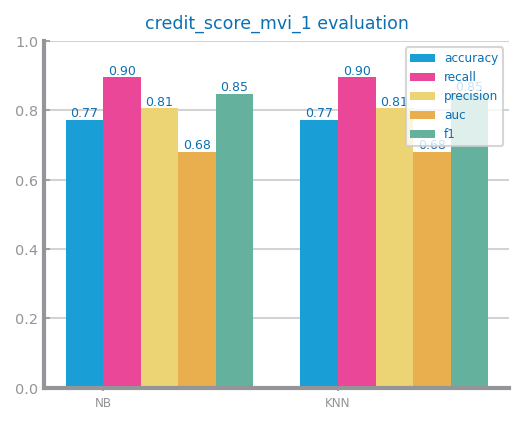

In [13]:
from numpy import ndarray
from pandas import DataFrame, read_csv
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import plot_multibar_chart, CLASS_EVAL_METRICS, run_NB, run_KNN
from sklearn.model_selection import train_test_split

def evaluate_approach(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    #eval_NB: dict[str, float] = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    if eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = [eval_KNN[met]]
    return eval


file_tag = 'credit_score_mvi_1'
target = 'Credit_Score'
y = data_mvi_1[target]
X = data_mvi_1.drop(columns = target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)


figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}_eval.png")
show()


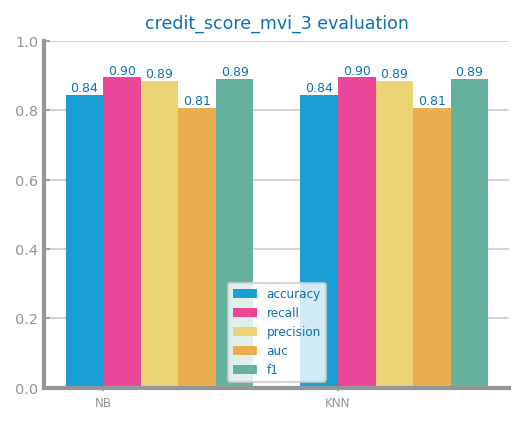

In [14]:
file_tag = 'credit_score_mvi_3'
target = 'Credit_Score'
y = data_mvi_3[target]
X = data_mvi_3.drop(columns = target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)


figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}_eval.png")
show()

### Outliers treatment

Original data: (100000, 48)
Data after dropping outliers: (70603, 48)


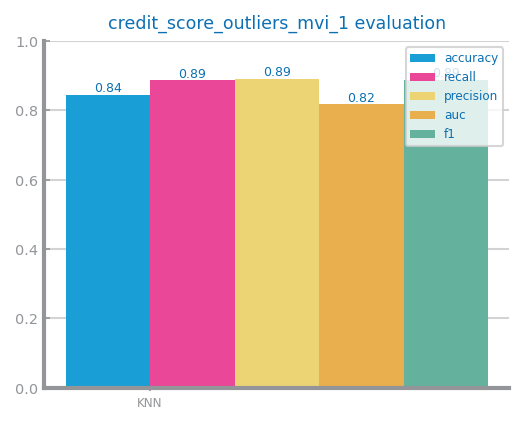

Data after replacing outliers: (100000, 48)


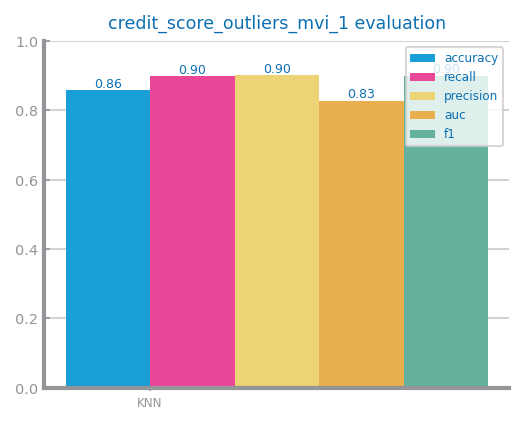

Data after truncating outliers: (100000, 48)


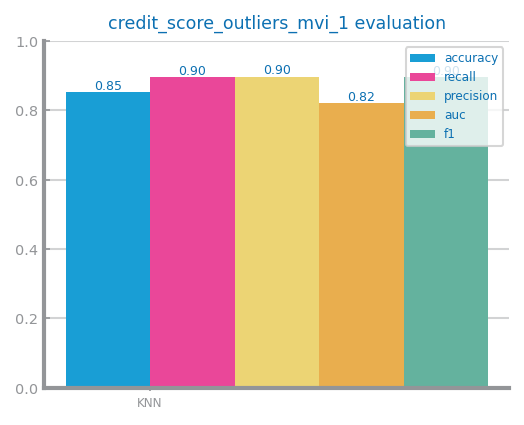

Data after dropping outliers: (70323, 48)


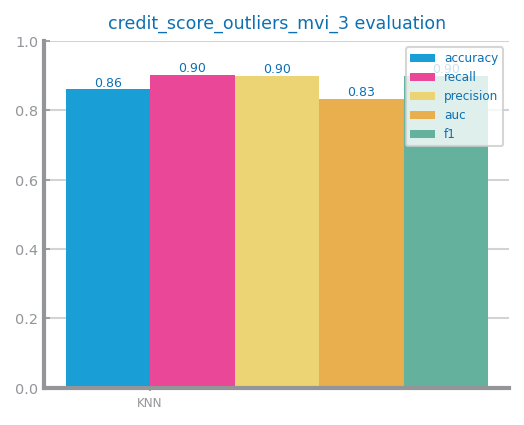

Data after replacing outliers: (100000, 48)


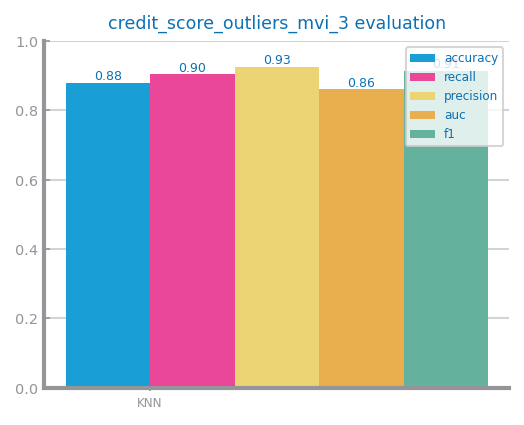

Data after truncating outliers: (100000, 48)


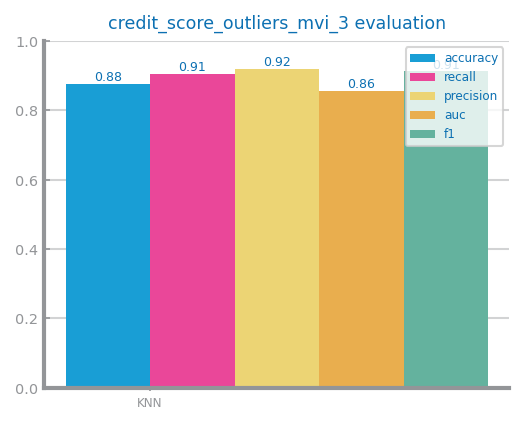

In [15]:
print(f"Original data: {data_mvi_3.shape}")

n_std: int = NR_STDEV
numeric_vars: list[str] = get_variable_types(data_mvi_3)["numeric"]
def evaluate_approach(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    #eval_NB: dict[str, float] = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    if eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = [eval_KNN[met]]
    return eval


for dataset in ["mvi_1", "mvi_3"]:
# Alternative 1: Dropping Outliers

    df: DataFrame = data_mvi_3.copy(deep=True) if dataset == 'mvi_3' else data_mvi_1.copy(deep=True)
    file_tag = f'credit_score_outliers_{dataset}'
    target = 'Credit_Score'
    if numeric_vars is not None:
        
        summary5: DataFrame = data_mvi_3[numeric_vars].describe()
        for var in numeric_vars:
            top_threshold, bottom_threshold = determine_outlier_thresholds_for_var(
                summary5[var],
                std_based=False
            )
            outliers: Series = df[(df[var] > top_threshold) | (df[var] < bottom_threshold)]
            df.drop(outliers.index, axis=0, inplace=True)
        print(f"Data after dropping outliers: {df.shape}")

        
        y = df[target]
        X = df.drop(columns = target)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        train = pd.concat([X_train, y_train], axis=1)
        test = pd.concat([X_test, y_test], axis=1)


        figure()
        eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
        plot_multibar_chart(
            ["KNN"], eval, title=f"{file_tag} evaluation", percentage=True
        )
        savefig(f"images/{file_tag}_drop_iqr_eval.png")
        show()
    else:
        print("There are no numeric variables")

    # Alternative 2: Replacing outliers with fixed value

    df: DataFrame = data_mvi_3.copy(deep=True) if dataset == 'mvi_3' else data_mvi_1.copy(deep=True)
    if [] != numeric_vars:
        for var in numeric_vars:
            top, bottom = determine_outlier_thresholds_for_var(summary5[var], std_based=False)
            median: float = df[var].median()
            df[var] = df[var].apply(lambda x: median if x > top or x < bottom else x)
        print("Data after replacing outliers:", df.shape)

        y = df[target]
        X = df.drop(columns = target)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        train = pd.concat([X_train, y_train], axis=1)
        test = pd.concat([X_test, y_test], axis=1)


        figure()
        eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
        plot_multibar_chart(
            ["KNN"], eval, title=f"{file_tag} evaluation", percentage=True
        )
        savefig(f"images/{file_tag}_replace_iqr_eval.png")
        show()
    else:
        print("There are no numeric variables")


    # Alternative 3: Truncating outliers
    df: DataFrame = data_mvi_3.copy(deep=True) if dataset == 'mvi_3' else data_mvi_1.copy(deep=True)
    if [] != numeric_vars:
        for var in numeric_vars:
            top, bottom = determine_outlier_thresholds_for_var(summary5[var], std_based=False)
            df[var] = df[var].apply(
                lambda x: top if x > top else bottom if x < bottom else x
            )
        print("Data after truncating outliers:", df.shape)

        y = df[target]
        X = df.drop(columns = target)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        train = pd.concat([X_train, y_train], axis=1)
        test = pd.concat([X_test, y_test], axis=1)


        figure()
        eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
        plot_multibar_chart(
            ["KNN"], eval, title=f"{file_tag} evaluation", percentage=True
        )
        savefig(f"images/{file_tag}_trunc_iqr_eval.png")
        show()
    else:
        print("There are no numeric variables")



Original data: (100000, 48)
Data after dropping outliers: (42692, 48)


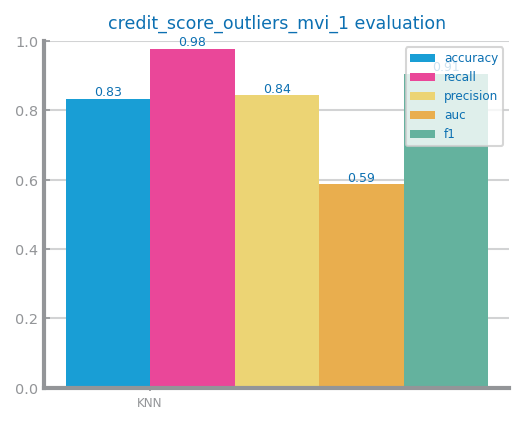

Data after replacing outliers: (100000, 48)


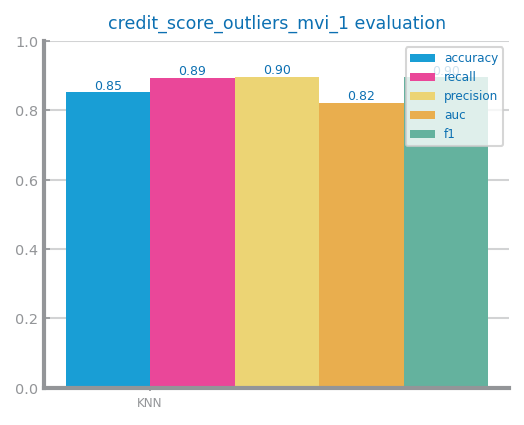

Data after truncating outliers: (100000, 48)


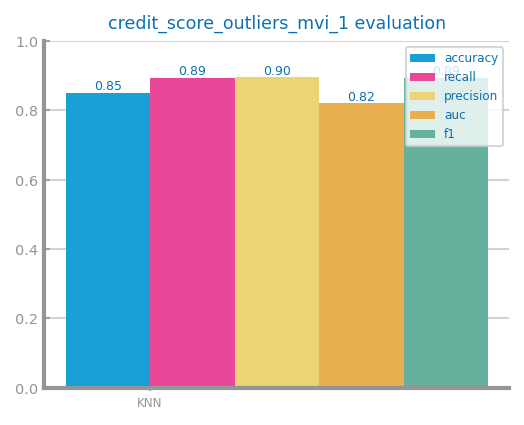

Data after dropping outliers: (42108, 48)


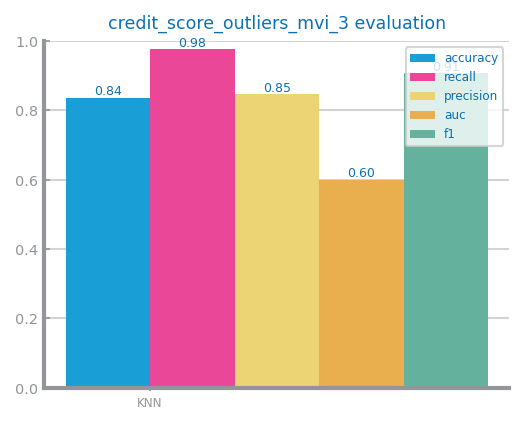

Data after replacing outliers: (100000, 48)


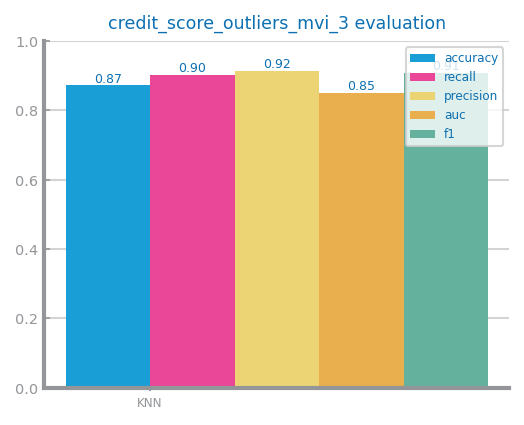

Data after truncating outliers: (100000, 48)


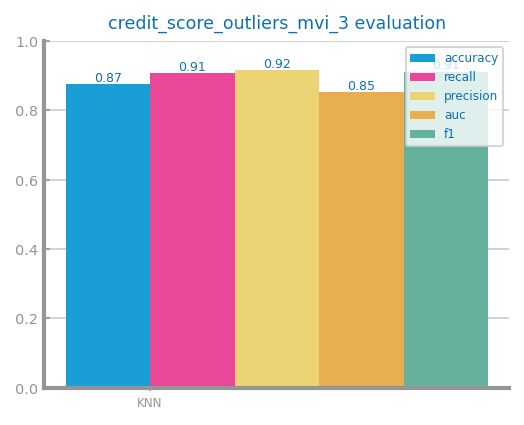

In [16]:
print(f"Original data: {data_mvi_3.shape}")

n_std: int = NR_STDEV
numeric_vars: list[str] = get_variable_types(data_mvi_3)["numeric"]
def evaluate_approach(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    #eval_NB: dict[str, float] = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    if eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = [eval_KNN[met]]
    return eval


for dataset in ["mvi_1", "mvi_3"]:
# Alternative 1: Dropping Outliers

    df: DataFrame = data_mvi_3.copy(deep=True) if dataset == 'mvi_3' else data_mvi_1.copy(deep=True)
    file_tag = f'credit_score_outliers_{dataset}'
    target = 'Credit_Score'
    if numeric_vars is not None:
        
        summary5: DataFrame = data_mvi_3[numeric_vars].describe()
        for var in numeric_vars:
            top_threshold, bottom_threshold = determine_outlier_thresholds_for_var(
                summary5[var],
            )
            outliers: Series = df[(df[var] > top_threshold) | (df[var] < bottom_threshold)]
            df.drop(outliers.index, axis=0, inplace=True)
        print(f"Data after dropping outliers: {df.shape}")

        
        y = df[target]
        X = df.drop(columns = target)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        train = pd.concat([X_train, y_train], axis=1)
        test = pd.concat([X_test, y_test], axis=1)


        figure()
        eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
        plot_multibar_chart(
            ["KNN"], eval, title=f"{file_tag} evaluation", percentage=True
        )
        savefig(f"images/{file_tag}_drop_std_dev_eval.png")
        show()
    else:
        print("There are no numeric variables")

    # Alternative 2: Replacing outliers with fixed value

    df: DataFrame = data_mvi_3.copy(deep=True) if dataset == 'mvi_3' else data_mvi_1.copy(deep=True)
    if [] != numeric_vars:
        for var in numeric_vars:
            top, bottom = determine_outlier_thresholds_for_var(summary5[var])
            median: float = df[var].median()
            df[var] = df[var].apply(lambda x: median if x > top or x < bottom else x)
        print("Data after replacing outliers:", df.shape)

        y = df[target]
        X = df.drop(columns = target)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        train = pd.concat([X_train, y_train], axis=1)
        test = pd.concat([X_test, y_test], axis=1)


        figure()
        eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
        plot_multibar_chart(
            ["KNN"], eval, title=f"{file_tag} evaluation", percentage=True
        )
        savefig(f"images/{file_tag}_replace_std_dev_eval.png")
        show()
    else:
        print("There are no numeric variables")


    # Alternative 3: Truncating outliers
    df: DataFrame = data_mvi_3.copy(deep=True) if dataset == 'mvi_3' else data_mvi_1.copy(deep=True)
    if [] != numeric_vars:
        for var in numeric_vars:
            top, bottom = determine_outlier_thresholds_for_var(summary5[var], std_based=False)
            df[var] = df[var].apply(
                lambda x: top if x > top else bottom if x < bottom else x
            )
        print("Data after truncating outliers:", df.shape)

        y = df[target]
        X = df.drop(columns = target)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        train = pd.concat([X_train, y_train], axis=1)
        test = pd.concat([X_test, y_test], axis=1)


        figure()
        eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
        plot_multibar_chart(
            ["KNN"], eval, title=f"{file_tag} evaluation", percentage=True
        )
        savefig(f"images/{file_tag}_trunc_std_dev_eval.png")
        show()
    else:
        print("There are no numeric variables")






In [17]:
#Assign the best to the best dataset mvi
data_mvi_3_outliers_replace = data_mvi_3.copy()
summary5: DataFrame = data_mvi_3_outliers_replace[numeric_vars].describe()
if [] != numeric_vars:
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var], std_based=False)
        median: float = data_mvi_3_outliers_replace[var].median()
        data_mvi_3[var] = data_mvi_3_outliers_replace[var].apply(lambda x: median if x > top or x < bottom else x)
    print("Data after replacing outliers:", data_mvi_3_outliers_replace.shape)
    print(data_mvi_3_outliers_replace.head())
else:
    print("There are no numeric variables")

Data after replacing outliers: (100000, 48)
        Customer_ID  Age  SSN_Area_Code  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Delay_from_due_date  NumofDelayedPayment  ChangedCreditLimit  NumCreditInquiries  CreditMix  OutstandingDebt  CreditUtilizationRatio  Payment_of_Min_Amount  TotalEMIpermonth  Amountinvestedmonthly  Payment_Behaviour  MonthlyBalance  Credit_Score  Loan_Type_Student_Loan  Loan_Type_Mortgage_Loan  Loan_Type_Not_Specified  Loan_Type_Credit_Builder_Loan  Loan_Type_Personal_Loan  Loan_Type_Auto_Loan  Loan_Type_Debt_Consolidation_Loan  Loan_Type_Home_Equity_Loan  Loan_Type_Payday_Loan  Credit_History_Age_Months  Occupation_Accountant  Occupation_Architect  Occupation_Developer  Occupation_Doctor  Occupation_Engineer  Occupation_Entrepreneur  Occupation_Journalist  Occupation_Lawyer  Occupation_Manager  Occupation_Mechanic  Occupation_Media_Manager  Occupation_Musician  Occupation_Scientist  Occupation_Teacher  Occupation_

### Scaling

In [20]:
from pandas import read_csv, DataFrame, Series
from sklearn.preprocessing import StandardScaler

def evaluate_approach(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    #eval_NB: dict[str, float] = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    if eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = [eval_KNN[met]]
    return eval

target = "Credit_Score"

vars: list[str] = data_mvi_3.columns.to_list()
target_data: Series = data_mvi_3.copy().pop(target)

file_tag = f'credit_score_scalling_mvi_3_'

#Alternative 1: Standard Scalar
transf: StandardScaler = StandardScaler(with_mean=True, with_std=True, copy=True).fit(
    data_mvi_3
)
df_zscore = DataFrame(transf.transform(data_mvi_3), index=data_mvi_3.index)
df_zscore[target] = target_data
df_zscore.columns = vars

y = df_zscore[target]
X = df_zscore.drop(columns = target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)


figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}std_scalar_eval.png")
show()

         Customer_ID   Age  SSN_Area_Code  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Delay_from_due_date  NumofDelayedPayment  ChangedCreditLimit  NumCreditInquiries  CreditMix  OutstandingDebt  CreditUtilizationRatio  Payment_of_Min_Amount  TotalEMIpermonth  Amountinvestedmonthly  Payment_Behaviour  MonthlyBalance  Loan_Type_Student_Loan  Loan_Type_Mortgage_Loan  Loan_Type_Not_Specified  Loan_Type_Credit_Builder_Loan  Loan_Type_Personal_Loan  Loan_Type_Auto_Loan  Loan_Type_Debt_Consolidation_Loan  Loan_Type_Home_Equity_Loan  Loan_Type_Payday_Loan  Credit_History_Age_Months  Occupation_Accountant  Occupation_Architect  Occupation_Developer  Occupation_Doctor  Occupation_Engineer  Occupation_Entrepreneur  Occupation_Journalist  Occupation_Lawyer  Occupation_Manager  Occupation_Mechanic  Occupation_Media_Manager  Occupation_Musician  Occupation_Scientist  Occupation_Teacher  Occupation_Writer  Month_sin  Month_cos
ID                         

KeyError: 'Credit_Score'

### Balancing

### Feature selection